#### Music-conditioned human motion generation using AIST++ dataset

AIST++ dataset contains 1408 sequences of 3D human dance motion, each sequence with duration 7-48 seconds, along with corresponding music.

Task: Flow-matching for generating realistic human dance motion conditioned on music segment, and potential with a seed motion sequence.

Input: Segment of music -> embed with some pretrained model
Output: Sequence of 3D Human body keypoints data of shape (N frames x 17 joints x 3 coordinates) following COCO format at 60Fps. (sample visualization below)

<img src="./aistpp-dataset-dance-screen.png" width="350">

In [10]:
import os
import sys

import glob

In [138]:
import numpy as np
import pickle

import jax
import jax.numpy as jnp

import torch


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# download AIST++ keypoints3d data from https://google.github.io/aistplusplus_dataset/download.html
# download AIST++ music dataset from https://github.com/Garfield-kh/TM2D

In [ ]:
MUSIC_FOLDER = 'data/aist_plusplus/all_music'
KEYPOINTS_FOLDER = 'data/aist_plusplus/keypoints3d'
MOTIONS_FOLDER = 'data/aist_plusplus/motions'

music_list = sorted(glob.glob(f'{MUSIC_FOLDER}/*.wav'))
keypoints_list = sorted(glob.glob(f'{KEYPOINTS_FOLDER}/*.pkl'))

print(len(music_list))
print(music_list[:3])
print(len(keypoints_list))
print(keypoints_list[:3])

60
['data/aist_plusplus/all_music/mBR0.wav', 'data/aist_plusplus/all_music/mBR1.wav', 'data/aist_plusplus/all_music/mBR2.wav']
1408
['data/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch01.pkl', 'data/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch02.pkl', 'data/aist_plusplus/keypoints3d/gBR_sBM_cAll_d04_mBR0_ch03.pkl']


In [36]:
try:
  import librosa
except ImportError:
  !pip install librosa
  import librosa

try:
  import pywt
except ImportError:
  !pip install PyWavelets
  import pywt

try:
  import soundfile as sf
except ImportError:
  !pip install soundfile
  import soundfile as sf

In [ ]:

with open(keypoints_list[0], 'rb') as f:
  sample_keypoints = pickle.load(f)
print(sample_keypoints.keys())
print(sample_keypoints[list(sample_keypoints.keys())[0]].shape)
print(sample_keypoints[list(sample_keypoints.keys())[1]].shape)


dict_keys(['keypoints3d', 'keypoints3d_optim'])
(720, 17, 3)
(720, 17, 3)


##### Embed (and save) music data with pretrained model (MusicFM)

In [179]:
EMBED_MODEL_SR = 24000  # 24kHz
KEYPOINT_FRAME_RATE = 60  # 60 fps

In [ ]:
y, sr = librosa.load(music_list[0])
y_len_s = y.shape[0] / sr

print('loaded: ', music_list[0], y.shape, 'sr:', sr, 'len (sec):', y_len_s)

y_resampled = librosa.resample(y, orig_sr=sr, target_sr=EMBED_MODEL_SR)
print(y.shape, y_resampled.shape)
# save
sf.write(f'data/aist_plusplus/sample_resampled_{EMBED_MODEL_SR}.wav', y_resampled, EMBED_MODEL_SR)

loaded:  data/aist_plusplus/all_music/mBR0.wav (1190700,) sr: 22050 len (sec): 54.0
(1190700,) (1296001,)


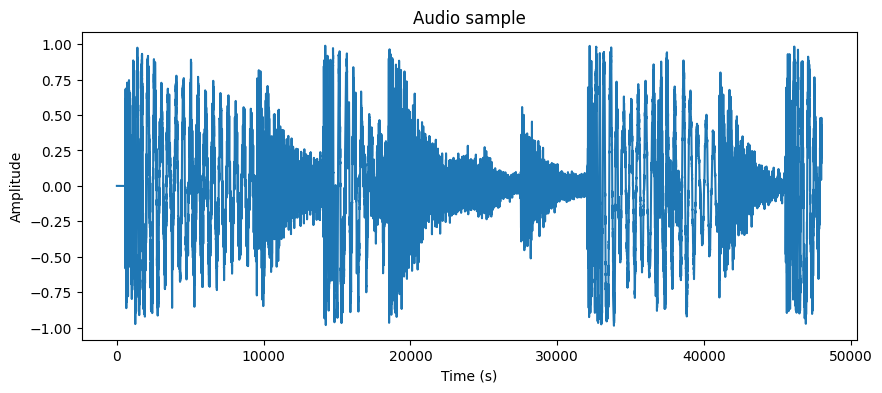

In [178]:
# plot sample
plt.figure(figsize=(10, 4))
plt.plot(y_resampled[:2*EMBED_MODEL_SR])
plt.title('Audio sample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
# load musicfm model

In [132]:
!mkdir -p $(pwd)/models/musicfm/data/
!wget -P $(pwd)/models/musicfm/data/ https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
!wget -P $(pwd)/models/musicfm/data/ https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt

--2025-03-31 20:06:34--  https://huggingface.co/minzwon/MusicFM/resolve/main/msd_stats.json
Resolving huggingface.co (huggingface.co)... 2600:9000:2046:1c00:17:b174:6d00:93a1, 2600:9000:2046:b000:17:b174:6d00:93a1, 2600:9000:2046:a000:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:2046:1c00:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2277 (2.2K) [text/plain]
Saving to: ‘/media/lysonn/bigpot/dev/play/quantfin_examples/flow-diffusion/models/musicfm/data/msd_stats.json’

msd_stats.json      100%[===================>]   2.22K  --.-KB/s    in 0s      

2025-03-31 20:06:34 (131 MB/s) - ‘/media/lysonn/bigpot/dev/play/quantfin_examples/flow-diffusion/models/musicfm/data/msd_stats.json’ saved [2277/2277]

--2025-03-31 20:06:34--  https://huggingface.co/minzwon/MusicFM/resolve/main/pretrained_msd.pt
Resolving huggingface.co (huggingface.co)... 2600:9000:2046:4a00:17:b174:6d00:93a1, 2600:9000:2046:b000:17:b174:6d00:93

In [135]:
!git clone https://github.com/minzwon/musicfm.git $(pwd)/models/musicfm/musicfm

Cloning into '/media/lysonn/bigpot/dev/play/quantfin_examples/flow-diffusion/models/musicfm/musicfm'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 100 (delta 26), reused 18 (delta 18), pack-reused 69 (from 1)
Receiving objects: 100% (100/100), 1.25 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [140]:
!pip install einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
MUSICFM_PATH = './models/musicfm/'
sys.path.append(MUSICFM_PATH)

from musicfm.model.musicfm_25hz import MusicFM25Hz

musicfm = MusicFM25Hz(
    is_flash=False,
    stat_path=os.path.join(MUSICFM_PATH, "data", "msd_stats.json"),
    model_path=os.path.join(MUSICFM_PATH, "data", "pretrained_msd.pt"),
)
musicfm.eval()

In [ ]:
# embed sample audio file
emb = musicfm.get_latent(torch.from_numpy(y_resampled.reshape(1, -1)))
print(emb.shape)

# resample embedding frame rate from 25Hz to 60Hz to match keypoint data


n_frame = int(y_len_s * KEYPOINT_FRAME_RATE)
token_emb = torch.nn.AdaptiveAvgPool1d(n_frame)(emb.transpose(1, 2)).transpose(1, 2)
print(token_emb.shape, token_emb.shape[1] / KEYPOINT_FRAME_RATE)

plt.figure(figsize=(6, 4))
plt.imshow(token_emb[0].detach().numpy().T, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.title('Token embedding')
plt.xlabel('Time')
plt.ylabel('Embedding dimension')
plt.colorbar()
plt.show()

torch.Size([1, 1350, 1024])


In [ ]:
for i, music_file in enumerate(music_list):
  y, sr = librosa.load(music_file)
  y_resampled = librosa.resample(y, orig_sr=sr, target_sr=EMBED_MODEL_SR)
  y_len_s = y.shape[0] / sr

  emb = musicfm.get_latent(torch.from_numpy(y_resampled.reshape(1, -1)))
  n_frame = int(y_len_s * KEYPOINT_FRAME_RATE)
  token_emb = torch.nn.AdaptiveAvgPool1d(n_frame)(emb.transpose(1, 2)).transpose(1, 2)

  # save token embedding
  music_name = os.path.basename(music_file).split('.')[0]
  embeds_file = os.path.join(MUSIC_FOLDER, f'{music_name}_musicfm_emb_60Hz.npy')
  np.save(embeds_file, token_emb.detach().numpy())

  print(f'{i+1}/{len(music_list)}: loaded: {music_file}, {y.shape}, sr: {sr}, len (sec): {y_len_s}. '
        f'saved: {embeds_file}, token emb shape: {token_emb.shape}, {token_emb.shape[1] / KEYPOINT_FRAME_RATE} sec')

1/60: loaded: data/aist_plusplus/all_music/mBR0.wav, (1190700,), sr: 22050, len (sec): 54.0. saved: data/aist_plusplus/all_music/mBR0_musicfm_emb_60Hz.npy, token emb shape: torch.Size([1, 3240, 1024]), 54.0 sec
